# Collate sample-level and cell-level metadata for all datasets

Joyce Kang

Last updated June 2023

**General Steps:**
1. Make Sample level metadata
    - Start with samples passing QC in original studies
    - Remove individuals for whom we could not confidently call HLA alleles (see 2_HLA_imp notebook for how we determine this)
    - Add genotype PCs to control for ancestry
2. Make Cell level metadata
    - Start with cells passing QC in original studies
    - Subset to individuals passing sample-level QC
    - Define major cell types consistently across datasets

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggpubr)
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(vcfR)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(patchwork)
    library(stringr)
    library(gridExtra)
    
    require(gdata)
    library(readxl)
})
source('../utils.R')

# Make sample-level metadata

Combine metadata for all 4 datasets so they have consistent column names:

- `Geno_ID`: Subject identifier matching genotyping data
- `Sample`: Subject identifier matching scRNA data
- `Female`: 1 (Female) or 0 (Male)
- `Age`
- `Chemistry`: 10x version (if applicable)
- `Site`: site of processing (if applicable)
- `Processing_Batch`: Batch (if applicable)
- `Case_control`: Disease or control (if applicable)
- `gPC1-5`: genotype PCs

Remove samples with inconclusive HLA imputation results.

## AMP2RA

In [2]:
# AMP RA clinical metadata (from Fan Zhang)
path_clin = '/data/srlab1/public/srcollab/AMP_Phase_2/clinical_data/metadata_clin_donor_singlecell.xlsx'
clin_meta = read_excel(path_clin)
clin_meta$sample = clin_meta$mRNA_run

# Samples included in our study (AMP samples with genotype and RNA, exclude duplicates)
samples = readRDS('/data/srlab2/jkang/scHLA/AMP_HLA_alleles/ID_mapping_nodup.rds')
samples %>% head(3)

# Remove extraneous samples from clin_meta
clin_meta = clin_meta[which(clin_meta$sample %in% samples$mapping_RNAID), ]
clin_meta %>% head(3)
colnames(clin_meta)

# Use the genotype labels from samples
rownames(samples) = samples$mapping_RNAID
samples = samples[clin_meta$sample, ] # sync the order of samples with clin_meta
all(rownames(samples) == clin_meta$sample)
clin_meta$geno_ID = samples$mapping_genoID

# Convert "treatment" column from 1,2,3,4 to RA (1,2,3) /OA (4)
clin_meta = clin_meta %>% mutate(case_control = ifelse(treatment == 4, 'OA', 'RA'))

write.csv(clin_meta, '../../data/meta/clinical_meta_AMP2RA.csv', quote = F)

# Select columns for eQTL covariates
sample_meta_AMP2RA = clin_meta %>% dplyr::select(geno_ID, sample, sex, age, site, case_control)
colnames(sample_meta_AMP2RA) = c('Geno_ID', 'Sample', 'Sex', 'Age', 'Site', 'Case_control')
sample_meta_AMP2RA$Age = as.numeric(sample_meta_AMP2RA$Age)

# Recode sex as "female" one-hot variable
sample_meta_AMP2RA = sample_meta_AMP2RA %>% mutate(Female = ifelse(Sex == 'Female', 1, 0))
sample_meta_AMP2RA$Sex = NULL
sample_meta_AMP2RA$Dataset = 'AMP2RA'
sample_meta_AMP2RA %>% head(4)
nrow(sample_meta_AMP2RA)
write.csv(sample_meta_AMP2RA, '../../data/meta/sample_meta_AMP2RA.csv', quote = F)

# Write sample list
write.table(sample_meta_AMP2RA$Sample, '../../data/meta/sample_list_AMP2RA.txt', 
            quote = F, col.names = F, row.names = F)

,mapping_RNAID,mapping_genoID
,<chr>,<chr>
1,BRI-413,300-0143
2,BRI-546,300-0144
3,BRI-589,300-0145


subject_id,pipeline_date,site,treatment,biopsied,sex,age,CDAI,disease_duration,tissue_type,krenn_lining,krenn_inflammation,single_cell_tech,cell_count_to_10x,mRNA_run,protein_run,atac_run,qc,sample
<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
301-0267,2019-08-06,University of Pittsburgh,4,Knee,Female,70,NA,NA,Arthroplasty,NA,NA,CITEseq + flow/bulk + re-freeze,15000,BRI-399,BRI-400,BRI-448,Pass,BRI-399
300-0302,2019-08-06,Cedars,1,Knee,Female,77,15,2.1,Biopsy,1.67,2.33,CITEseq,15000,BRI-401,BRI-402,NA,Pass,BRI-401
300-0150,2019-08-06,University of Rochester,2,Wrist,Female,28,22,1.5,Synovectomy,0.67,2.67,CITEseq + flow/bulk + re-freeze,15000,BRI-403,BRI-404,BRI-449,Pass,BRI-403


[1] "subject_id"         "pipeline_date"      "site"              
 [4] "treatment"          "biopsied"           "sex"               
 [7] "age"                "CDAI"               "disease_duration"  
[10] "tissue_type"        "krenn_lining"       "krenn_inflammation"
[13] "single_cell_tech"   "cell_count_to_10x"  "mRNA_run"          
[16] "protein_run"        "atac_run"           "qc"                
[19] "sample"

[1] TRUE

Geno_ID,Sample,Age,Site,Case_control,Female,Dataset
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
301-0267,BRI-399,70,University of Pittsburgh,OA,1,AMP2RA
300-0302,BRI-401,77,Cedars,RA,1,AMP2RA
300-0150,BRI-403,28,University of Rochester,RA,1,AMP2RA
300-0310,BRI-405,62,Cedars,RA,1,AMP2RA


[1] 78

**REMOVE SAMPLES with missing HLA allele(s)**

In [3]:
missingHLA = c('300-0143', '300-1934', '300-2666', '300-0531', '300-0413', '300-2658', 
               '300-0411-V0-14-C1', '300-0469-F2-16-PXD1', '300-0462')
QC_sample_meta = sample_meta_AMP2RA %>% filter(!Geno_ID %in% missingHLA)
nrow(QC_sample_meta)
write.csv(QC_sample_meta, '../../data/meta/sample_meta_AMP2RA_completeHLA.csv', quote = F)
write.table(QC_sample_meta$Sample, '../../data/meta/sample_list_AMP2RA_completeHLA.txt', 
            quote = F, col.names = F, row.names = F)

[1] 69

Make V2 and V3_format sample lists

In [4]:
V2_format = c('BRI-399','BRI-401','BRI-403','BRI-405','BRI-407','BRI-409','BRI-411','BRI-413','BRI-415',
    'BRI-417', 'BRI-419', 'BRI-421','BRI-425','BRI-427','BRI-429','BRI-431','BRI-436','BRI-438','BRI-440','BRI-442')
QC_sample_meta$Sample[which(QC_sample_meta$Sample %in% V2_format)]

QC_sample_meta$Sample[which(QC_sample_meta$Sample %in% V2_format)] %>% length()
QC_sample_meta$Sample[which(!QC_sample_meta$Sample %in% V2_format)] %>% length()

write.table(QC_sample_meta$Sample[which(QC_sample_meta$Sample %in% V2_format)], 
            '../../data/meta/samples.list.AMP2RA.formatV2.txt', quote = F, col.names = F, row.names = F)

write.table(QC_sample_meta$Sample[which(!QC_sample_meta$Sample %in% V2_format)], 
            '../../data/meta/samples.list.AMP2RA.formatV3.txt', quote = F, col.names = F, row.names = F)

[1] "BRI-399" "BRI-401" "BRI-403" "BRI-405" "BRI-407" "BRI-409" "BRI-411"
 [8] "BRI-415" "BRI-417" "BRI-419" "BRI-421" "BRI-425" "BRI-427" "BRI-429"
[15] "BRI-431" "BRI-436" "BRI-438" "BRI-442"

[1] 18

[1] 51

case/control numbers

In [5]:
table(QC_sample_meta$Case_control)


OA RA 
 9 60 

## Smillie2019

In [6]:
## Smillie2019 clinical metadata (from Karthik Jagadeesh & Kushal Dey)
path_clin = '/data/srlab1/jkang/hla/data/Smillie2019/metadata/meta_25samples.csv'
clin_meta = read.csv(path_clin, header = TRUE)
clin_meta %>% head(4)
colnames(clin_meta)

,GenoID,PID,NID,file,Subject_ID,PRISM_ID,Disease,Location,Age,Duration,Gender,Smoking,genotyping_run
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,202279080102_R08C01,PRISM_9767,N24,metadata2,N24,9767,Colitis,Rectum,35,19,Female,Never,ccdg_broad
2,202279080112_R06C01,PRISM_9669,N10,metadata2,N10,9669,HC,Right_Colon,73,0,Female,Never,ccdg_broad
3,202279080112_R09C02,PRISM_9674,N13,metadata2,N13,9674,HC,Right_Colon,60,0,Female,Former,ccdg_broad
4,202596060040_R04C02,PRISM_7526,N19,metadata2,N19,7526,Colitis,Transverse_Colon,58,14,Female,Never,ccdg_broad


[1] "GenoID"         "PID"            "NID"            "file"          
 [5] "Subject_ID"     "PRISM_ID"       "Disease"        "Location"      
 [9] "Age"            "Duration"       "Gender"         "Smoking"       
[13] "genotyping_run"

Do we have any batch variables?

In [7]:
## Add column for 10x version (obtained from Supp table 1)
clin_meta$tenxversion = "10xv2"
v1_Samples = c('N10', 'N13', 'N19', 'N16', 'N17', 'N21', 'N15', 'N20', 'N14', 'N7', 'N12', 'N9')
clin_meta$tenxversion[which(clin_meta$Subject_ID %in% v1_Samples)] = "10xv1"
table(clin_meta$tenxversion, clin_meta$genotyping_run)

write.csv(clin_meta, '../../data/meta/clinical_meta_Smillie.csv', quote = F)

       
        ccdg_broad Helmsley_PRISM Helmsley_Xavier
  10xv1          8              1               3
  10xv2          7              1               5

In [8]:
## Select columns for eQTL covariates
sample_meta_Smillie = clin_meta %>% dplyr::select(GenoID, Subject_ID, Gender, Age, tenxversion, genotyping_run, Disease)
colnames(sample_meta_Smillie) = c('Geno_ID', 'Sample', 'Sex', 'Age', 'Chemistry', 'Genotyping_array', 'Case_control')

# Recode sex as female
sample_meta_Smillie = sample_meta_Smillie %>% mutate(Female = ifelse(Sex == 'Female', 1, 0))
sample_meta_Smillie$Sex = NULL
sample_meta_Smillie$Age = as.numeric(sample_meta_Smillie$Age)
sample_meta_Smillie$Dataset = 'Smillie2019'
sample_meta_Smillie %>% head(3)

# Write sample meta
write.csv(sample_meta_Smillie, '../../data/meta/sample_meta_Smillie.csv', quote = F)

# Write sample list
write.table(sample_meta_Smillie$Sample, '../../data/meta/sample_list_Smillie.txt', 
            quote = F, col.names = F, row.names = F)

,Geno_ID,Sample,Age,Chemistry,Genotyping_array,Case_control,Female,Dataset
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,202279080102_R08C01,N24,35,10xv2,ccdg_broad,Colitis,1,Smillie2019
2,202279080112_R06C01,N10,73,10xv1,ccdg_broad,HC,1,Smillie2019
3,202279080112_R09C02,N13,60,10xv1,ccdg_broad,HC,1,Smillie2019


REMOVE SAMPLES with missing HLA allele(s)

In [9]:
missingHLA = c('203259090242_R02C01', '200556980121_R09C01', '200556970035_R10C02')
QC_sample_meta = sample_meta_Smillie %>% filter(!Geno_ID %in% missingHLA)
nrow(QC_sample_meta)
write.csv(QC_sample_meta, '../../data/meta/sample_meta_Smillie_completeHLA.csv', quote = F)
write.table(QC_sample_meta$Sample, '../../data/meta/sample_list_Smillie_completeHLA.txt', 
            quote = F, col.names = F, row.names = F)

[1] 22

In [10]:
QC_sample_meta = read.csv('../../data/meta/sample_meta_Smillie_completeHLA.csv')
# Write sample list
write.table(QC_sample_meta$Sample, '../../data/meta/sample_list_Smillie_completeHLA.txt', 
            quote = F, col.names = F, row.names = F)

table(QC_sample_meta$Case_control)


Colitis      HC 
     13       9 

## Randolph 2021

In [11]:
## Randolph2021 clinical metadata (from original Randolph et al. paper, Supp Table 1)
path_clin = '/data/srlab1/jkang/hla/data/Randolph2021/SuppTable1.tsv'

clin_meta = read.delim(path_clin, header = T)
clin_meta %>% head(3)
colnames(clin_meta)
dim(clin_meta)

clin_meta = clin_meta %>% filter(!indiv_ID %in% c('HMN52545', 'HMN52561'))
dim(clin_meta)

write.csv(clin_meta, '../../data/meta/clinical_meta_Randolph.csv', quote = F)

,infection_ID,indiv_ID,infection_status,batchID,capture,batch_capture,sex,age,genetic_ancestry,Afr_admixture,CD4_T_propBimodal,CD8_T_propBimodal,B_propBimodal,monocytes_combined_propBimodal,NK_combined_propBimodal,cell_count,time_course
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,HMN83551_NI,HMN83551,NI,B1,c1,B1_c1,Male,41,EUR,1e-05,0.00000,0.06001,0.16582,0.02572,0.20596,1013,NA
2,HMN83552_NI,HMN83552,NI,B1,c1,B1_c1,Male,54,EUR,1e-05,0.00000,0.06537,0.36825,0.03156,0.03452,1442,NA
3,HMN83553_flu,HMN83553,flu,B1,c1,B1_c1,Male,53,EUR,1e-05,0.01571,0.07233,0.17346,0.42830,0.22165,1602,low


[1] "infection_ID"                   "indiv_ID"                      
 [3] "infection_status"               "batchID"                       
 [5] "capture"                        "batch_capture"                 
 [7] "sex"                            "age"                           
 [9] "genetic_ancestry"               "Afr_admixture"                 
[11] "CD4_T_propBimodal"              "CD8_T_propBimodal"             
[13] "B_propBimodal"                  "monocytes_combined_propBimodal"
[15] "NK_combined_propBimodal"        "cell_count"                    
[17] "time_course"

[1] 180  17

[1] 176  17

HMN52545: no genotyping

HMN52561: excluded on the basis of our IBD threshold (IBD PI_HAT > 0.9); duplicated with HMN171224 - checked Table S1, both are Male, European, mid-50s (likely duplicate)

In [12]:
## Select columns for eQTL covariates
sample_meta_Randolph = clin_meta %>% dplyr::select(indiv_ID, infection_ID, sex, age, batch_capture)
colnames(sample_meta_Randolph) = c('Geno_ID', 'Sample', 'Sex', 'Age', 'Batch')

# Recode sex as female (note: this cohort is all male)
sample_meta_Randolph = sample_meta_Randolph %>% mutate(Female = ifelse(Sex == 'Female', 1, 0))
sample_meta_Randolph$Sex = NULL
sample_meta_Randolph$Age = as.numeric(sample_meta_Randolph$Age)
sample_meta_Randolph$Dataset = 'Randolph2021'
sample_meta_Randolph %>% head(4)
unique(sample_meta_Randolph$Geno_ID) %>% length()

# Write sample meta
write.csv(sample_meta_Randolph, '../../data/meta/sample_meta_Randolph.csv', quote = F)

# Write sample list
write.table(sample_meta_Randolph$Sample, '../../data/meta/sample_list_Randolph.txt', 
            quote = F, col.names = F, row.names = F)

,Geno_ID,Sample,Age,Batch,Female,Dataset
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,HMN83551,HMN83551_NI,41,B1_c1,0,Randolph2021
2,HMN83552,HMN83552_NI,54,B1_c1,0,Randolph2021
3,HMN83553,HMN83553_flu,53,B1_c1,0,Randolph2021
4,HMN83554,HMN83554_flu,41,B1_c1,0,Randolph2021


[1] 88

REMOVE SAMPLES with missing HLA allele(s)

In [13]:
missingHLA = c('HMN83554', 'HMN83557', 'HMN83578', 'HMN83579', 'HMN52532', 'HMN83573', 
               'HMN52552', 'HMN52542', 'HMN52556', 'HMN52557',
               'HMN52549', 'HMN52559', 'HMN171215', 'HMN171230', 'HMN171228')
QC_sample_meta = sample_meta_Randolph %>% filter(!Geno_ID %in% missingHLA)
nrow(QC_sample_meta)
write.csv(QC_sample_meta, '../../data/meta/sample_meta_Randolph_completeHLA.csv', quote = F)
write.table(QC_sample_meta$Sample, '../../data/meta/sample_list_Randolph_completeHLA.txt', 
            quote = F, col.names = F, row.names = F)

[1] 146

## OneK1K

In [14]:
# From Laurie Rumker
sample_meta = read.csv('/data/srlab1/jkang/hla/data/OneK1K/sampleXmeta_Laurie.csv')
sample_meta$Sex_F = 1 - sample_meta$Sex_M # Use F as reference instead
colnames(sample_meta)
table(sample_meta$Autoimmune_Disease)

[1] "id"                       "age"                     
 [3] "batch"                    "Sex_M"                   
 [5] "Autoimmune_Disease"       "Diabetes_type1"          
 [7] "Diabetes_type2"           "Rheumatoid_arthritis"    
 [9] "UlcerativeColitis"        "Hyperthyroidism"         
[11] "Hypertension"             "Hypercholesterolaemia"   
[13] "Cancer"                   "Eye_Disease"             
[15] "Osteoporosis"             "COPD"                    
[17] "Statin"                   "ACE_inhibitor"           
[19] "AngiotensinReptorBlocker" "CalciumChannelBlocker"   
[21] "BetaBlocker"              "BetaAgonist"             
[23] "Diuretic"                 "Oral_hypoglycaemic"      
[25] "Insulin"                  "OCP"                     
[27] "Paracetamol"              "Aspirin"                 
[29] "Colchicine"               "PPI"                     
[31] "Thyroxine"                "SmokingStatus_N"         
[33] "SmokingStatus_P"          "SmokingStatus_C"         
[35] "Autoimmune_Disease_Other" "Ca_Type"                 
[37] "Eye_DiseaseType"          "Other_Disease"           
[39] "Other_Meds"               "Sex_F"


  0   1 
514  23 

In [15]:
sample_meta = sample_meta[, c('id', 'id', 'age', 'Sex_F', 'batch', 'Autoimmune_Disease')]
colnames(sample_meta) = c('Geno_ID', 'Sample', 'Age', 'Female', 'Batch', 'Case_control')
sample_meta$Dataset = 'OneK1K'
sample_meta %>% head(4)

,Geno_ID,Sample,Age,Female,Batch,Case_control,Dataset
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,691_692,691_692,66,0,1,NA,OneK1K
2,693_694,693_694,88,1,1,0,OneK1K
3,688_689,688_689,66,0,1,1,OneK1K
4,683_684,683_684,78,0,1,0,OneK1K


**Remove samples with missing genotype data**
505_506, 553_554, 565_566 removed due to elevated missing data rates

In [16]:
sample_meta = sample_meta %>% filter(! Sample %in% c('505_506', '553_554', '565_566'))
dim(sample_meta)

[1] 970   7

**Remove samples missing in mapping file**

In [17]:
sample_meta %>% filter(Sample == '966_967')
sample_meta = sample_meta %>% filter(!Sample %in% c('966_967'))
dim(sample_meta)
write.csv(sample_meta, '../../data/meta/sample_meta_OneK1K.csv', quote = F)

Geno_ID,Sample,Age,Female,Batch,Case_control,Dataset
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
966_967,966_967,62,0,37.35033,NA,OneK1K


[1] 969   7

**Remove samples without complete HLA alleles**

In [18]:
missing = readRDS('../../data/hla_alleles/1K1K_df_missing.rds')
missing %>% head(4)

sample_meta = sample_meta %>% filter(! Sample %in% missing$X0)
nrow(sample_meta)
write.csv(sample_meta, '../../data/meta/sample_meta_OneK1K_completeHLA.csv', quote = F)

## Write sample list
sample_meta = read.csv('../../data/meta/sample_meta_OneK1K_completeHLA.csv')
write.table(sample_meta$Sample, '../../data/meta/sample_list_OneK1K_completeHLA.txt', quote = F, col.names = F, row.names = F)

,X0,X0.1,X0.2
,<chr>,<chr>,<chr>
2,690_691,HLA_B,1
3,692_693,HLA_DPB1,1
4,842_843,HLA_A,1
5,850_851,HLA_B,1


[1] 909

**Split into 3 batches**

For purposes of running the scHLApers pipeline, split the dataset into 3 batches

In [19]:
sample_meta_group1 = sample_meta %>% filter(Batch <= 30)
write.csv(sample_meta_group1, '../../data/meta/sample_meta_OneK1K_group1.csv', quote = F)
write.table(sample_meta_group1$Sample, '../../data/meta/sample_meta_OneK1K_group1.txt', 
            quote = F, col.names = F, row.names = F)

sample_meta_group2 = sample_meta %>% filter(Batch > 30, Batch <= 60)
write.csv(sample_meta_group2, '../../data/meta/sample_meta_OneK1K_group2.csv', quote = F)
write.table(sample_meta_group2$Sample, '../../data/meta/sample_meta_OneK1K_group2.txt', 
            quote = F, col.names = F, row.names = F)

sample_meta_group3 = sample_meta %>% filter(Batch > 60)
write.csv(sample_meta_group3, '../../data/meta/sample_meta_OneK1K_group3.csv', quote = F)
write.table(sample_meta_group3$Sample, '../../data/meta/sample_meta_OneK1K_group3.txt', 
            quote = F, col.names = F, row.names = F)

nrow(sample_meta_group1)
sample_meta_group1 %>% head(4)

[1] 366

,X,Geno_ID,Sample,Age,Female,Batch,Case_control,Dataset
,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
1,1,691_692,691_692,66,0,1,NA,OneK1K
2,2,693_694,693_694,88,1,1,0,OneK1K
3,3,688_689,688_689,66,0,1,1,OneK1K
4,4,683_684,683_684,78,0,1,0,OneK1K


## Process Ancestry gPCs

In [20]:
# Read in gPCs (calculated by Sid Gurajala)
gPCs = read.table('/data/srlab/ssg34/scHLA/data/pca/AMP_1K1K_Randolph_Smillie.merged.final.pruned.eigenvec', row.names = 2)
gPCs = gPCs[, -1]
colnames(gPCs) = paste0('gPC', 1:20)
gPCs %>% head(3)

AMP2RA_samples = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv', row.names = 1)
rownames(AMP2RA_samples) = AMP2RA_samples$Sample
AMP2RA_gPCs = gPCs[AMP2RA_samples$Geno_ID, 1:5]
AMP2RA_samples = cbind(AMP2RA_samples, AMP2RA_gPCs)

Smillie_samples = read.csv('../../data/meta/sample_meta_Smillie_completeHLA.csv', row.names = 1)
rownames(Smillie_samples) = Smillie_samples$Sample
Smillie_gPCs = gPCs[Smillie_samples$Geno_ID, 1:5]
Smillie_samples = cbind(Smillie_samples, Smillie_gPCs)

Randolph_samples = read.csv('../../data/meta/sample_meta_Randolph_completeHLA.csv', row.names = 1)
rownames(Randolph_samples) = Randolph_samples$Sample
Randolph_gPCs = gPCs[Randolph_samples$Geno_ID, 1:5]
Randolph_samples = cbind(Randolph_samples, Randolph_gPCs)

OneK1K_samples = read.csv('../../data/meta/sample_meta_OneK1K_completeHLA.csv', row.names = 1)
rownames(OneK1K_samples) = OneK1K_samples$Sample
OneK1K_gPCs = gPCs[OneK1K_samples$Geno_ID, 1:5]
OneK1K_samples = cbind(OneK1K_samples, OneK1K_gPCs)

,gPC1,gPC2,gPC3,gPC4,gPC5,gPC6,gPC7,gPC8,gPC9,gPC10,gPC11,gPC12,gPC13,gPC14,gPC15,gPC16,gPC17,gPC18,gPC19,gPC20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1_1,0.00639148,-0.00185234,-0.00772719,-0.00584238,0.0053594,8.78957e-05,0.00138132,0.000188738,-0.000136933,-0.000429445,0.000575516,0.00218711,-0.00124649,-0.00240782,0.00397125,-0.00567694,0.00258820,0.00130711,0.002431700,-0.003579890
200-0034-W24-02-C1,-0.02421880,0.08503460,0.01664270,-0.04412310,-0.0310624,-6.39115e-03,-0.00173818,0.002789960,0.019135400,0.029920100,-0.000266094,0.01080210,-0.01147980,0.00614634,-0.00460149,-0.00201658,0.00265565,-0.00436074,0.000598795,-0.003025790
200-0056,-0.02518060,0.08537670,0.01689000,-0.04498800,-0.0283500,-3.90261e-03,-0.00518584,0.001634000,0.022552400,0.029467900,-0.000531233,0.01066340,-0.00959201,0.00518274,-0.00783134,0.00308040,0.00543253,0.00290348,0.003063640,0.000331779


## Save the final sample metadata!

In [21]:
head(AMP2RA_samples, 2)
head(Randolph_samples, 2)
head(Smillie_samples, 2)
head(OneK1K_samples, 2)

write.csv(AMP2RA_samples, '../../data/meta/sample_meta_AMP2RA_completeHLA.csv', quote = F)
write.csv(Randolph_samples, '../../data/meta/sample_meta_Randolph_completeHLA.csv', quote = F)
write.csv(Smillie_samples, '../../data/meta/sample_meta_Smillie_completeHLA.csv', quote = F)
write.csv(OneK1K_samples, '../../data/meta/sample_meta_OneK1K_completeHLA.csv', quote = F)

,Geno_ID,Sample,Age,Site,Case_control,Female,Dataset,gPC1,gPC2,gPC3,gPC4,gPC5
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRI-399,301-0267,BRI-399,70,University of Pittsburgh,OA,1,AMP2RA,0.00697193,-0.001935340,-0.00341045,-0.00542254,0.001496150
BRI-401,300-0302,BRI-401,77,Cedars,RA,1,AMP2RA,0.00504535,-0.000640029,0.00543787,0.00175097,-0.000925546


,Geno_ID,Sample,Age,Batch,Female,Dataset,gPC1,gPC2,gPC3,gPC4,gPC5
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMN83551_NI,HMN83551,HMN83551_NI,41,B1_c1,0,Randolph2021,0.00671998,-0.00269240,-0.00802549,-0.0046330,-0.000776995
HMN83552_NI,HMN83552,HMN83552_NI,54,B1_c1,0,Randolph2021,0.00619977,-0.00322609,-0.00116037,-0.0033029,-0.003468960


,Geno_ID,Sample,Age,Chemistry,Genotyping_array,Case_control,Female,Dataset,gPC1,gPC2,gPC3,gPC4,gPC5
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N24,202279080102_R08C01,N24,35,10xv2,ccdg_broad,Colitis,1,Smillie2019,0.00431944,-0.001599700,0.00778036,0.00567526,0.000912485
N10,202279080112_R06C01,N10,73,10xv1,ccdg_broad,HC,1,Smillie2019,0.00604928,-0.000254902,-0.01093120,-0.00891237,0.001981880


,Geno_ID,Sample,Age,Female,Batch,Case_control,Dataset,gPC1,gPC2,gPC3,gPC4,gPC5
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
691_692,691_692,691_692,66,0,1,NA,OneK1K,0.00582226,-0.00369853,-0.00716669,-0.00543094,-0.004686770
693_694,693_694,693_694,88,1,1,0,OneK1K,0.00454864,-0.00247861,-0.00782701,-0.00562812,0.000970699


## Combine and plot cohort characteristics

Plot gPCs across all genotyped individuals

In [22]:
eigenval = read.table('/data/srlab/ssg34/scHLA/data/pca/AMP_1K1K_Randolph_Smillie.merged.final.pruned.eigenval')
pve <- data.frame(PC = 1:20, pve = eigenval/sum(eigenval)*100) # https://speciationgenomics.github.io/pca/

AMP2RA_samples = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv')
Randolph_samples = read.csv('../../data/meta/sample_meta_Randolph_completeHLA.csv')
Smillie_samples = read.csv('../../data/meta/sample_meta_Smillie_completeHLA.csv')
OneK1K_samples = read.csv('../../data/meta/sample_meta_OneK1K_completeHLA.csv')

# Genotype sample IDs
donors_AMP = read.table('/data/srlab2/jkang/scHLA/data_AMP_Phase2/AMPgeno/post_merged_auto.final.fam')$V2
donors_Smillie_ccdg = read.table('/data/srlab1/jkang/hla/data/Smillie2019/qc/ccdg_broad/ccdg_broad.final.maf0.01.fam')$V2
donors_Smillie_Helmsley = read.table('/data/srlab1/jkang/hla/data/Smillie2019/qc/Helmsley_merged_final.maf0.01.fam')$V2
donors_Randolph = read.table('/data/srlab/ssg34/scHLA/data/Randolph2021/qc/Randolph2021.hg19.final.Ref.MHC.m0.02.maf0.05.fam')$V2
donors_OneK1K = read.table('/data/srlab/external-data/1K1K_raw/geno/hg19/qc/1K1K.final.maf0.01.fam')$V2

gPCs$dataset = NA
gPCs$dataset[which(rownames(gPCs) %in% donors_AMP)] = 'Synovium (Illumina MEGA)'
gPCs$dataset[which(rownames(gPCs) %in% donors_Smillie_ccdg)] = 'Intestine (Illumina GSA)'
gPCs$dataset[which(rownames(gPCs) %in% donors_Smillie_Helmsley)] = 'Intestine (custom array)'
gPCs$dataset[which(rownames(gPCs) %in% donors_Randolph)] = 'PBMC-cultured (Low-pass WGS)'
gPCs$dataset[which(rownames(gPCs) %in% donors_OneK1K)] = 'PBMC-blood (Illumina GSA)'

gPCs$cohort = 'Not included in this study'
gPCs$cohort[which(rownames(gPCs) %in% AMP2RA_samples$Geno_ID)] = 'Synovium'
gPCs$cohort[which(rownames(gPCs) %in% Smillie_samples$Geno_ID)] = 'Intestine'
gPCs$cohort[which(rownames(gPCs) %in% Randolph_samples$Geno_ID)] = 'PBMC-cultured'
gPCs$cohort[which(rownames(gPCs) %in% OneK1K_samples$Geno_ID)] = 'PBMC-blood'

gPCs$instudy = FALSE
gPCs$instudy[which(gPCs$cohort != 'Not included in this study')] = TRUE

head(pve, 5)
sum(pve$V1[1:5])

,PC,V1
,<int>,<dbl>
1,1,47.653739
2,2,16.314569
3,3,5.534518
4,4,4.593484
5,5,2.537759


[1] 76.63407

In [23]:
gPCs$dataset = factor(gPCs$dataset, levels = c('Synovium (Illumina MEGA)', 'Intestine (Illumina GSA)',
                                    'Intestine (custom array)', 'PBMC-cultured (Low-pass WGS)', 'PBMC-blood (Illumina GSA)'))

In [24]:
fig.size(3.5, 12)
cohort_colors2 = c(cohort_colors, "Not included in this study" = "gray")

p12 = ggplot(gPCs %>% arrange(instudy)) +
    geom_point(aes(x = gPC1, y = gPC2, col = cohort), size = 2, shape = 1, stroke = .8) + theme_classic(base_size = 12) +
    facet_wrap(~ dataset, ncol = 5) + scale_color_manual(values = cohort_colors2) + 
    theme(legend.title=element_blank(), legend.position = 'none') + guides(color=guide_legend(ncol = 6)) +
    xlab(paste0('gPC1 (', round(pve[1, 'V1'], 2), '%)')) + ylab(paste0('gPC2 (', round(pve[2, 'V1'], 2), '%)')) +
    ggtitle('Genotype PCs') + theme(plot.title = element_text(hjust = 0.5)) 

In [25]:
p34 = ggplot(gPCs %>% arrange(instudy)) +
    geom_point(aes(x = gPC3, y = gPC4, col = cohort), size = 2, shape = 1, stroke = .8) + theme_classic(base_size = 12) +
    facet_wrap(~ dataset, ncol = 5) + scale_color_manual(values = cohort_colors2) + 
    theme(legend.title=element_blank(), legend.position = 'bottom') + guides(color=guide_legend(ncol = 6)) +
    xlab(paste0('gPC3 (', round(pve[3, 'V1'], 2), '%)')) + ylab(paste0('gPC4 (', round(pve[4, 'V1'], 2), '%)')) +
    theme(legend.text = element_text(size=14))

png 
  2

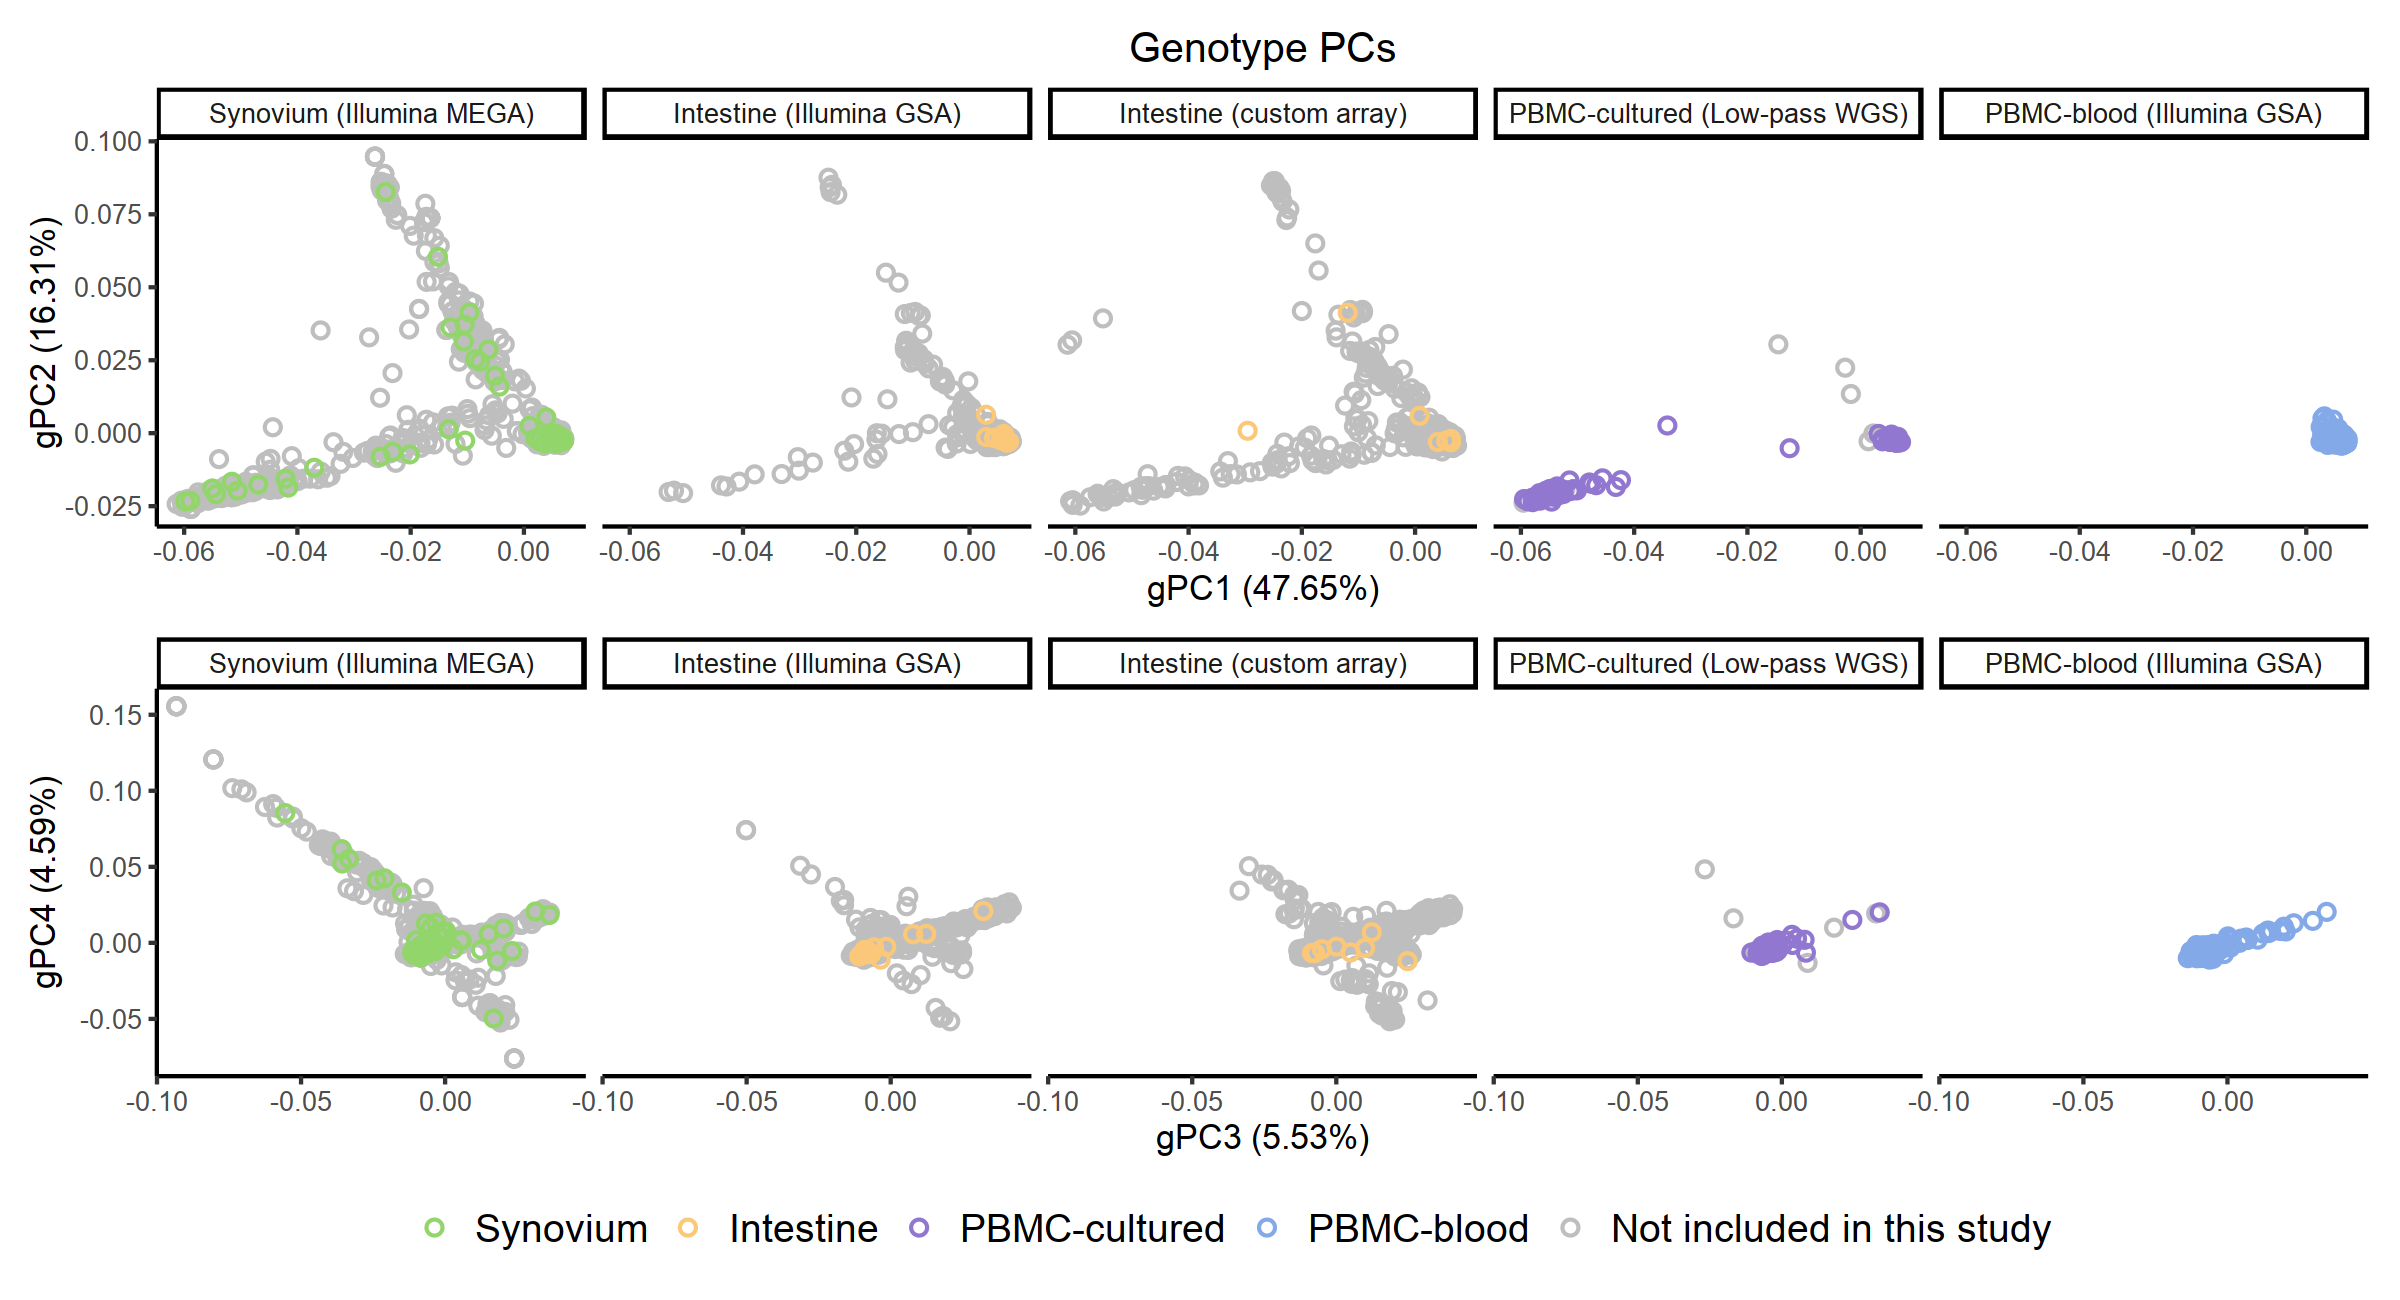

In [26]:
fig.size(6.5, 12)
png(file = '../../SuppFigs/Ancestry_PCA_all_cohorts_PC1-4.png', width = 12, height = 6.5, res= 300, units = 'in')
p12 / p34
dev.off()
p12 / p34

png 
  2

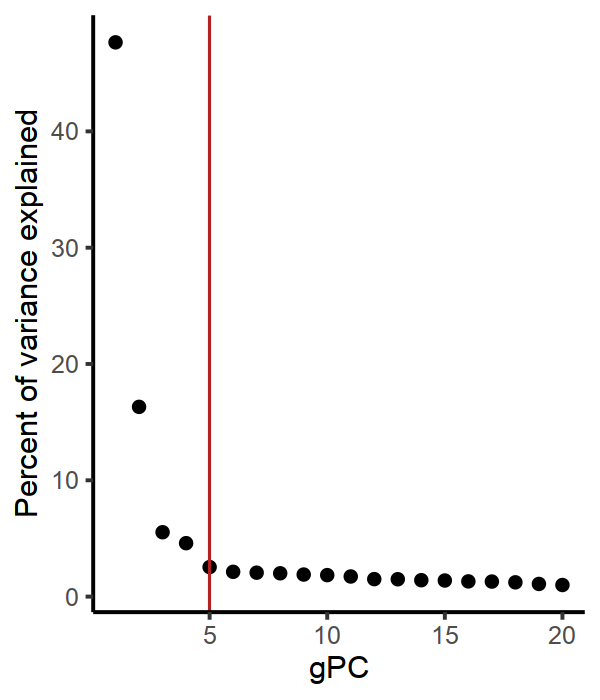

In [27]:
fig.size(3.5, 3)
png(file = '../../SuppFigs/Ancestry_PCA_pve.png', width = 3, height = 3.5, res= 300, units = 'in')
p = ggplot(pve) +
    geom_point(aes(x = PC, y = V1)) + theme_classic() + ylab('Percent of variance explained') + xlab('gPC') +
    geom_vline(xintercept = 5, col = 'firebrick', size = 0.4)
print(p)
dev.off()
p

### See if Randolph self-reported ancestry agrees w/ gPCs

In [28]:
Randolph_samples = read.csv('../../data/meta/sample_meta_Randolph_completeHLA.csv', row.names = 1)

## Randolph2021 clinical metadata (from original paper, Supp Table 1)
path_clin = '/data/srlab1/jkang/hla/data/Randolph2021/SuppTable1.tsv'
clin_meta = read.delim(path_clin, header = T)
Randolph_samples2 = merge(x = Randolph_samples, y = clin_meta[, c('infection_ID', 'genetic_ancestry', 'Afr_admixture')], 
                          all.x=TRUE, by.x = "Sample", by.y = "infection_ID")
Randolph_samples2 %>% head(4)

,Sample,Geno_ID,Age,Batch,Female,Dataset,gPC1,gPC2,gPC3,gPC4,gPC5,genetic_ancestry,Afr_admixture
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,HMN171216_flu,HMN171216,38,B12_c2,0,Randolph2021,0.00595190,-0.00272319,-0.00619394,-0.00551597,0.003069300,EUR,1e-05
2,HMN171216_NI,HMN171216,38,B12_c1,0,Randolph2021,0.00595190,-0.00272319,-0.00619394,-0.00551597,0.003069300,EUR,1e-05
3,HMN171217_flu,HMN171217,21,B15_c2,0,Randolph2021,0.00617387,-0.00295973,-0.00647264,-0.00544124,-0.000840714,EUR,1e-05
4,HMN171217_NI,HMN171217,21,B15_c1,0,Randolph2021,0.00617387,-0.00295973,-0.00647264,-0.00544124,-0.000840714,EUR,1e-05


png 
  2

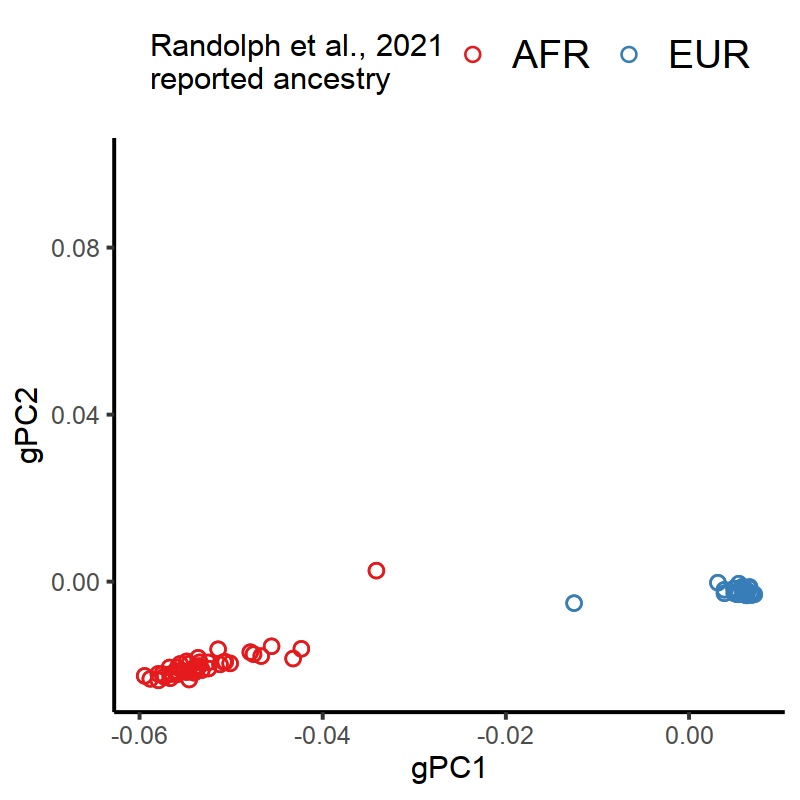

In [29]:
fig.size(4, 4)
png(file = '../../SuppFigs/Ancestry_PCA_Randolph_ancestry.png', width = 4, height = 4, res= 300, units = 'in')
p = ggplot(Randolph_samples2) +
    geom_point(aes(x = gPC1, y = gPC2, col = genetic_ancestry), size = 2, shape = 1) + theme_classic() +
    scale_color_brewer(palette = 'Set1') + labs(col = 'Randolph et al., 2021\nreported ancestry') + 
    ylim(-0.025, 0.1) + theme(legend.position = 'top') + theme(legend.text = element_text(size=14))
print(p)
dev.off()
p

[1] -0.9995479

png 
  2

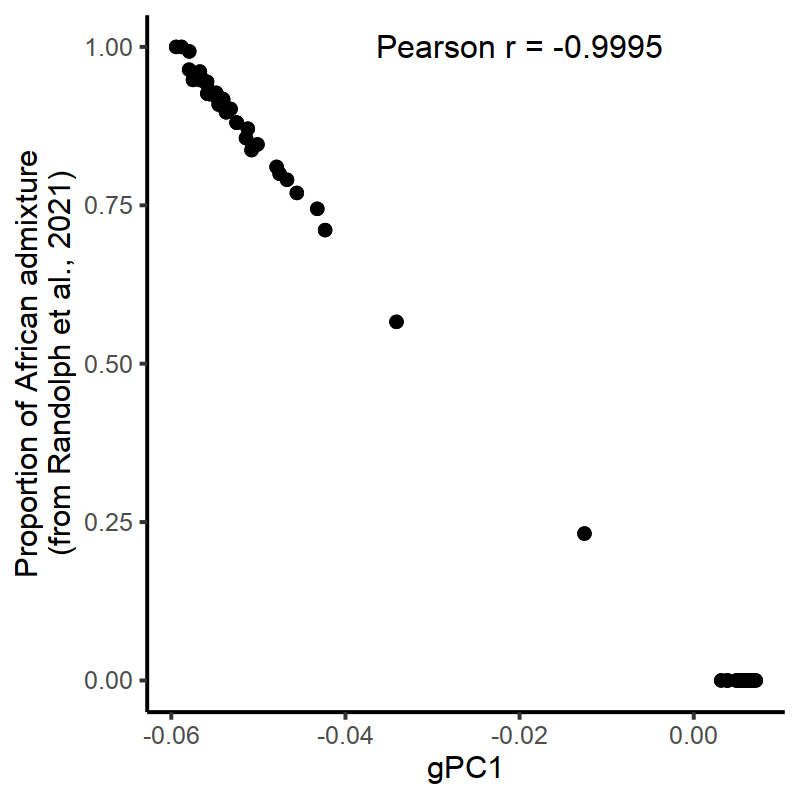

In [30]:
fig.size(4, 4)
cor(Randolph_samples2$gPC1, Randolph_samples2$Afr_admixture)
png(file = '../../SuppFigs/Ancestry_PCA_Randolph_admixture.png', width = 4, height = 4, res= 300, units = 'in')
p = ggplot(Randolph_samples2) +
    geom_point(aes(x = gPC1, y = Afr_admixture)) + theme_classic() +
    annotate("text", x=-0.02, y=1, label= "Pearson r = -0.9995", size = 4) +
    ylab('Proportion of African admixture\n(from Randolph et al., 2021)')
print(p)
dev.off()
p

### Plot cohort characteristics

In [31]:
shared_cols = c('Geno_ID', 'Sample', 'Age', 'Female', 'Dataset', 'gPC1', 'gPC2', 'gPC3', 'gPC4', 'gPC5')
combined_sample_meta = rbind(AMP2RA_samples[,shared_cols], Smillie_samples[,shared_cols], 
                             Randolph_samples[,shared_cols], OneK1K_samples[, shared_cols])

# reorder factor levels
combined_sample_meta$Dataset = revalue(combined_sample_meta$Dataset, old_new_dataset_names)
combined_sample_meta$Dataset = factor(combined_sample_meta$Dataset, levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



In [32]:
dataset_count = combined_sample_meta %>% group_by(Dataset) %>% dplyr::summarise(n = length(unique(Geno_ID)))

# Compute the position of labels
dataset_count = dataset_count %>% 
  arrange(desc(Dataset)) %>%
  mutate(prop = n / sum(dataset_count$n) * 100) %>%
  mutate(ypos = cumsum(prop) - 0.5 * prop ) 
dataset_count
sum(dataset_count$n)

Dataset,n,prop,ypos
<fct>,<int>,<dbl>,<dbl>
PBMC-blood,909,84.715750,42.35788
PBMC-cultured,73,6.803355,88.11743
Intestine,22,2.050326,92.54427
Synovium,69,6.430568,96.78472


[1] 1073

png 
  2

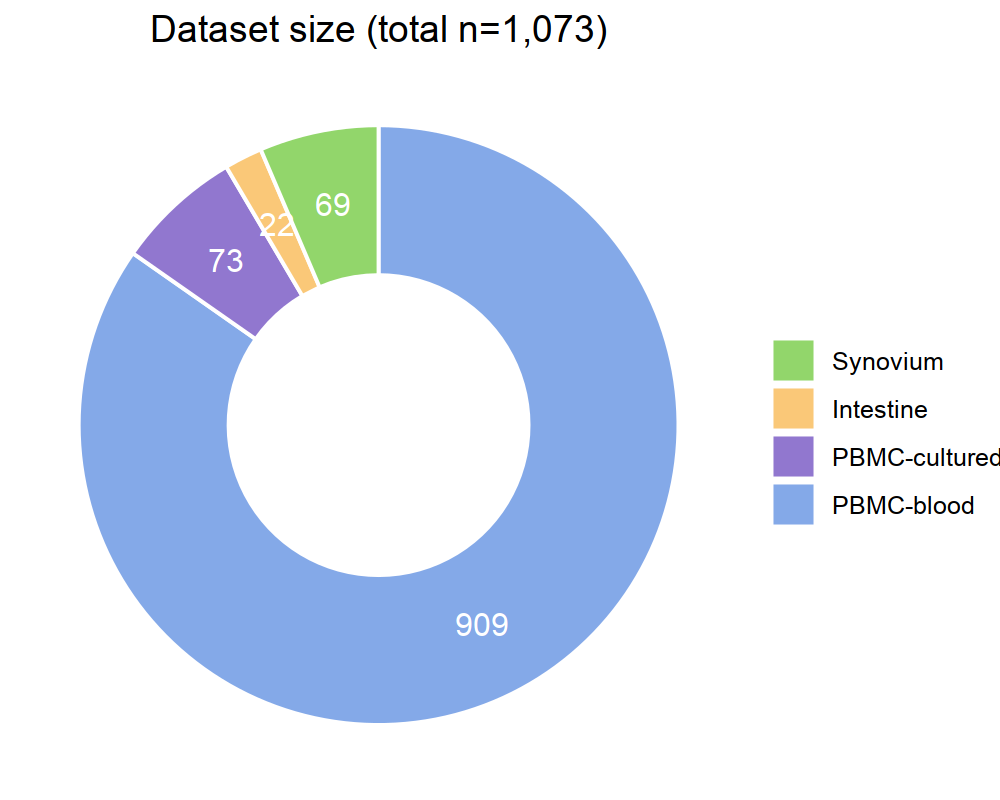

In [33]:
fig.size(4, 5)
png(file = '../../SuppFigs/dataset_size_pie.png', width = 5, height = 4, res= 300, units = 'in')

a = ggplot(dataset_count, aes(x=2, y=prop, fill=Dataset)) +
    geom_bar(stat="identity", width=1, color="white") +
    coord_polar("y", start=0) + theme_void() +
    scale_fill_manual(values = cohort_colors) +
    geom_text(aes(y = ypos, label = n), color = "white", size=4) +
    xlim(0.5, 2.5) + ggtitle(paste0('Dataset size (total n=', scales::comma(sum(dataset_count$n)), ')')) + 
    theme(plot.title = element_text(hjust = 0.5), legend.title=element_blank())
a
dev.off()
a

In [34]:
fig.size(3, 6)
b = ggplot(combined_sample_meta, aes(x=Age, fill=Dataset)) +
  geom_density(alpha = 0.5) + theme_classic() + scale_fill_manual(values = cohort_colors) +
    theme(legend.title=element_blank())

In [35]:
fig.size(3, 6)
combined_sample_meta = combined_sample_meta %>% mutate(Sex = ifelse(Female, 'Female', 'Male'))
c = ggplot(combined_sample_meta, aes(x=Dataset, fill=Sex)) +
  geom_bar() + theme_classic() +  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

png 
  2

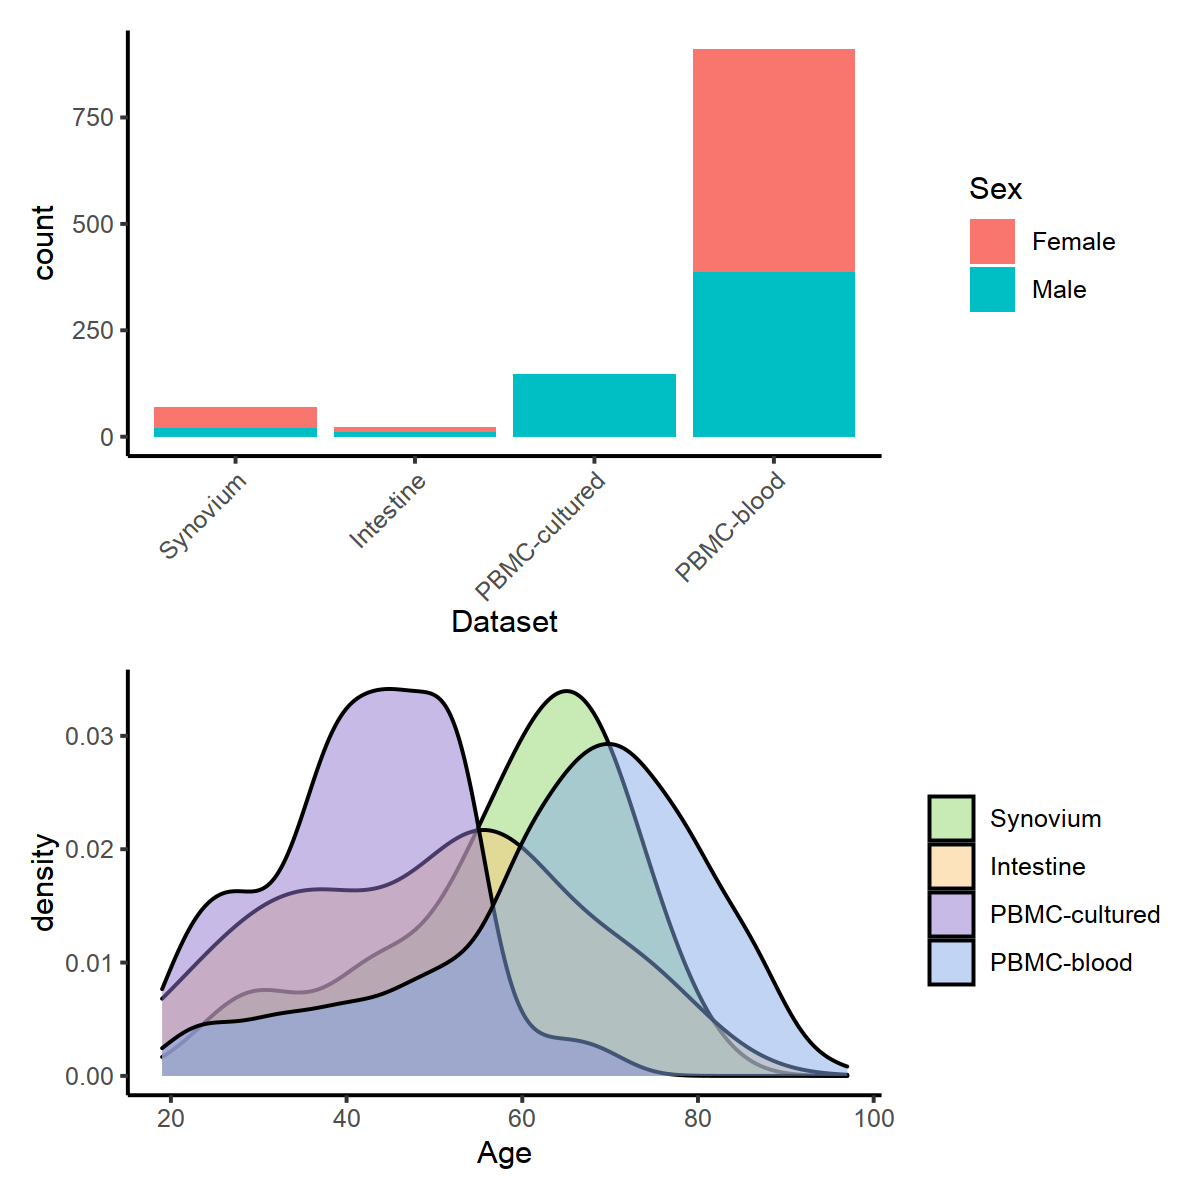

In [36]:
png(file = '../../SuppFigs/dataset_age_sex.png', 
    width = 6, height = 6, res= 300, units = 'in')
c/b
dev.off()

fig.size(6, 6)
c/b

# Make cell-level metadata

## AMP2RA

In [37]:
# Latest metadata from Katy as of 12/16/22
cell_meta = readRDS('/data/srlab/kweinand/scATAC_pipeline/output/multiome/CITErefs/reformat/AMP_CITE_metadata.rds')
unique(cell_meta$cluster_name)
cell_meta = cell_meta %>% filter(!is.na(cluster_name))
dim(cell_meta)

# Subset to cells in sample metadata
sample_meta = read.csv('../../data/meta/sample_meta_AMP2RA.csv')

cell_meta = cell_meta %>% filter(sample %in% sample_meta$Sample)
dim(cell_meta)
cell_meta %>% head(4)
cn = cell_meta %>% group_by(broadCT) %>%
    dplyr::summarise(n = n())
cn

[1] "B-2: IgM+IgD+TCL1A+ naive"             
 [2] "B-1: CD24++CD27+IgM+ unswitched memory"
 [3] "B-0: CD24+CD27+CD11b+ switched memory" 
 [4] "B-8: IgG1+IgG3+ plasma"                
 [5] "B-7: HLA-DR+IgG+ plasmablast"          
 [6] "B-3: IgM+IgD+CD1c+ MZ-like"            
 [7] "B-5: CD11c+LAMP1+ ABC"                 
 [8] "B-6: IgM+ plasma"                      
 [9] "B-4: AICDA+BCL6+ GC-like"              
[10] "T-6: CD4+ memory"                      
[11] "T-5: CD4+ GZMK+ memory"                
[12] "T-8: CD4+ CD25-high Treg"              
[13] "T-22: Vdelta1"                         
[14] "T-14: CD8+ GZMK+ memory"               
[15] "T-2: CD4+ IL7R+CCR5+ memory"           
[16] "T-12: CD4+ GNLY+"                      
[17] "T-4: CD4+ naive"                       
[18] "T-0: CD4+ IL7R+ memory"                
[19] "T-3: CD4+ Tfh/Tph"                     
[20] "T-1: CD4+ CD161+ memory"               
[21] "T-16: CD8+ CD45ROlow/naive"            
[22] "T-18: Proliferating"                   
[23] "T-20: CD38+"                           
[24] "T-13: CD8+ GZMK/B+ memory"             
[25] "T-21: Innate-like"                     
[26] "T-19: MT-high (low quality)"           
[27] "T-10: CD4+ OX40+NR3C1+"                
[28] "T-9: CD4+ CD25-low Treg"               
[29] "T-15: CD8+ GZMB+/TEMRA"                
[30] "T-11: CD4+ CD146+ memory"              
[31] "T-7: CD4+ Tph"                         
[32] "T-23: Vdelta2"                         
[33] "T-17: CD8+ activated/NK-like"          
[34] NA                                      
[35] "NK-1: CD56dim CD16+ IFNG+CD160+"       
[36] "NK-9: MT-high"                         
[37] "NK-12: IL7R+ ILC"                      
[38] "NK-0: CD56dim CD16+ IFNG-"             
[39] "NK-10: PCNA+ Proliferating"            
[40] "NK-5: CD56bright CD16- GZMA+CD69+"     
[41] "NK-11: MKI67+ Proliferating"           
[42] "NK-6: CD56bright CD16- GNLY+"          
[43] "NK-4: CD56bright CD16- GZMA+CD160+"    
[44] "NK-7: CD56bright CD16- GNLY+CD69+"     
[45] "NK-2: CD56dim CD16+ IFNG+CD160-"       
[46] "NK-13: IL7R+CD161+ ILC"                
[47] "NK-3: CD56dim CD16+ GZMB-"             
[48] "NK-8: CD56bright CD16- IFN response"   
[49] "M-10: DC2"                             
[50] "M-0: MERTK+ SELENOP+ LYVE1+"           
[51] "M-7: IL1B+ FCN1+"                      
[52] "M-9: DC3"                              
[53] "M-5: C1QA+"                            
[54] "M-1: MERTK+ SELENOP+ LYVE1-"           
[55] "M-2: MERTK+ S100A8+"                   
[56] "M-6: STAT1+ CXCL10+"                   
[57] "M-4: SPP1+"                            
[58] "M-13: pDC"                             
[59] "M-14: LAMP3+"                          
[60] "M-8: PLCG2+"                           
[61] "M-3: MERTK+ HBEGF+"                    
[62] "M-12: DC1"                             
[63] "M-11: DC4"                             
[64] "F-6: CXCL12+ SFRP1+ sublining"         
[65] "Mu-0: Mural"                           
[66] "F-4: DKK3+ sublining"                  
[67] "F-5: CD74-hi sublining"                
[68] "F-0: PRG4+ CLIC5+ lining"              
[69] "F-2: CD34+ sublining"                  
[70] "F-3: POSTN+ sublining"                 
[71] "F-1: PRG4+ lining"                     
[72] "F-7: NOTCH3+ sublining"                
[73] "F-8: RSPO3+ intermediate"              
[74] "E-1: LIFR+ venular"                    
[75] "E-0: SPARC+ capillary"                 
[76] "E-2: ICAM1+ venular"                   
[77] "E-3: NOTCH4+ arteriolar"               
[78] "E-4: Lymphatic"

[1] 314022     11

[1] 304467     11

,cell,sample,nUMI,nGene,percent_mito,broadCT,cluster_number,cluster_name,lowRes,midRes,highRes
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BRI-399_AAACGAACAGTCTGGC,BRI-399_AAACGAACAGTCTGGC,BRI-399,4354,1504,0.01515847,Bplasma,B-2,B-2: IgM+IgD+TCL1A+ naive,B-0: B cell group,B-0: B cell group,B-2: IgM+IgD+TCL1A+ naive
BRI-399_AAAGGATGTCTCAAGT,BRI-399_AAAGGATGTCTCAAGT,BRI-399,4236,1330,0.10339943,Bplasma,B-1,B-1: CD24++CD27+IgM+ unswitched memory,B-0: B cell group,B-0: B cell group,B-1: CD24++CD27+IgM+ unswitched memory
BRI-399_AAAGTGACATCGAACT,BRI-399_AAAGTGACATCGAACT,BRI-399,2877,1001,0.13277720,Bplasma,B-2,B-2: IgM+IgD+TCL1A+ naive,B-0: B cell group,B-0: B cell group,B-2: IgM+IgD+TCL1A+ naive
BRI-399_AAAGTGAGTGCACAAG,BRI-399_AAAGTGAGTGCACAAG,BRI-399,4073,1309,0.10508225,Bplasma,B-1,B-1: CD24++CD27+IgM+ unswitched memory,B-0: B cell group,B-0: B cell group,B-1: CD24++CD27+IgM+ unswitched memory


broadCT,n
<chr>,<int>
Bplasma,28273
endothelial,24261
myeloid,74678
NK,8296
stromal,77012
Tcell,91947


In [38]:
cell_meta_standard = cell_meta %>% dplyr::select(cell, sample, broadCT, cluster_name)
colnames(cell_meta_standard) = c('Cell', 'Sample', 'cell_type_major', 'cell_type_fine')
cell_meta_standard %>% head(4)

,Cell,Sample,cell_type_major,cell_type_fine
,<chr>,<chr>,<chr>,<chr>
BRI-399_AAACGAACAGTCTGGC,BRI-399_AAACGAACAGTCTGGC,BRI-399,Bplasma,B-2: IgM+IgD+TCL1A+ naive
BRI-399_AAAGGATGTCTCAAGT,BRI-399_AAAGGATGTCTCAAGT,BRI-399,Bplasma,B-1: CD24++CD27+IgM+ unswitched memory
BRI-399_AAAGTGACATCGAACT,BRI-399_AAAGTGACATCGAACT,BRI-399,Bplasma,B-2: IgM+IgD+TCL1A+ naive
BRI-399_AAAGTGAGTGCACAAG,BRI-399_AAAGTGAGTGCACAAG,BRI-399,Bplasma,B-1: CD24++CD27+IgM+ unswitched memory


In [39]:
unique(cell_meta_standard$cell_type_major) %>% sort() #%>% length()
unique(cell_meta_standard$cell_type_fine) %>% sort() #%>% length()

[1] "Bplasma"     "endothelial" "myeloid"     "NK"          "stromal"    
[6] "Tcell"

[1] "B-0: CD24+CD27+CD11b+ switched memory" 
 [2] "B-1: CD24++CD27+IgM+ unswitched memory"
 [3] "B-2: IgM+IgD+TCL1A+ naive"             
 [4] "B-3: IgM+IgD+CD1c+ MZ-like"            
 [5] "B-4: AICDA+BCL6+ GC-like"              
 [6] "B-5: CD11c+LAMP1+ ABC"                 
 [7] "B-6: IgM+ plasma"                      
 [8] "B-7: HLA-DR+IgG+ plasmablast"          
 [9] "B-8: IgG1+IgG3+ plasma"                
[10] "E-0: SPARC+ capillary"                 
[11] "E-1: LIFR+ venular"                    
[12] "E-2: ICAM1+ venular"                   
[13] "E-3: NOTCH4+ arteriolar"               
[14] "E-4: Lymphatic"                        
[15] "F-0: PRG4+ CLIC5+ lining"              
[16] "F-1: PRG4+ lining"                     
[17] "F-2: CD34+ sublining"                  
[18] "F-3: POSTN+ sublining"                 
[19] "F-4: DKK3+ sublining"                  
[20] "F-5: CD74-hi sublining"                
[21] "F-6: CXCL12+ SFRP1+ sublining"         
[22] "F-7: NOTCH3+ sublining"                
[23] "F-8: RSPO3+ intermediate"              
[24] "M-0: MERTK+ SELENOP+ LYVE1+"           
[25] "M-1: MERTK+ SELENOP+ LYVE1-"           
[26] "M-10: DC2"                             
[27] "M-11: DC4"                             
[28] "M-12: DC1"                             
[29] "M-13: pDC"                             
[30] "M-14: LAMP3+"                          
[31] "M-2: MERTK+ S100A8+"                   
[32] "M-3: MERTK+ HBEGF+"                    
[33] "M-4: SPP1+"                            
[34] "M-5: C1QA+"                            
[35] "M-6: STAT1+ CXCL10+"                   
[36] "M-7: IL1B+ FCN1+"                      
[37] "M-8: PLCG2+"                           
[38] "M-9: DC3"                              
[39] "Mu-0: Mural"                           
[40] "NK-0: CD56dim CD16+ IFNG-"             
[41] "NK-1: CD56dim CD16+ IFNG+CD160+"       
[42] "NK-10: PCNA+ Proliferating"            
[43] "NK-11: MKI67+ Proliferating"           
[44] "NK-12: IL7R+ ILC"                      
[45] "NK-13: IL7R+CD161+ ILC"                
[46] "NK-2: CD56dim CD16+ IFNG+CD160-"       
[47] "NK-3: CD56dim CD16+ GZMB-"             
[48] "NK-4: CD56bright CD16- GZMA+CD160+"    
[49] "NK-5: CD56bright CD16- GZMA+CD69+"     
[50] "NK-6: CD56bright CD16- GNLY+"          
[51] "NK-7: CD56bright CD16- GNLY+CD69+"     
[52] "NK-8: CD56bright CD16- IFN response"   
[53] "NK-9: MT-high"                         
[54] "T-0: CD4+ IL7R+ memory"                
[55] "T-1: CD4+ CD161+ memory"               
[56] "T-10: CD4+ OX40+NR3C1+"                
[57] "T-11: CD4+ CD146+ memory"              
[58] "T-12: CD4+ GNLY+"                      
[59] "T-13: CD8+ GZMK/B+ memory"             
[60] "T-14: CD8+ GZMK+ memory"               
[61] "T-15: CD8+ GZMB+/TEMRA"                
[62] "T-16: CD8+ CD45ROlow/naive"            
[63] "T-17: CD8+ activated/NK-like"          
[64] "T-18: Proliferating"                   
[65] "T-19: MT-high (low quality)"           
[66] "T-2: CD4+ IL7R+CCR5+ memory"           
[67] "T-20: CD38+"                           
[68] "T-21: Innate-like"                     
[69] "T-22: Vdelta1"                         
[70] "T-23: Vdelta2"                         
[71] "T-3: CD4+ Tfh/Tph"                     
[72] "T-4: CD4+ naive"                       
[73] "T-5: CD4+ GZMK+ memory"                
[74] "T-6: CD4+ memory"                      
[75] "T-7: CD4+ Tph"                         
[76] "T-8: CD4+ CD25-high Treg"              
[77] "T-9: CD4+ CD25-low Treg"

In [40]:
dim(cell_meta_standard)
unique(cell_meta_standard$Sample) %>% length()

[1] 304467      4

[1] 78

### Major resolution

In [41]:
## Move mural cells to an "other" category, rename fibroblasts from stromal
mural = c('Mu-0: Mural')
TOther = c('T-21: Innate-like')
cell_meta_standard = cell_meta_standard %>% 
            mutate(cell_type_major = ifelse(cell_type_major == 'Bplasma', 'B_plasma', cell_type_major)) %>% # rename
            mutate(cell_type_major = ifelse(cell_type_major == 'endothelial', 'Endothelial', cell_type_major)) %>% # rename
            mutate(cell_type_major = ifelse(cell_type_major == 'myeloid', 'Myeloid', cell_type_major)) %>% # rename
            mutate(cell_type_major = ifelse(cell_type_major == 'stromal', 'Fibroblast', cell_type_major)) %>% # rename stromal
            mutate(cell_type_major = ifelse(cell_type_major == 'Tcell', 'T', cell_type_major)) %>% # rename stromal
            mutate(cell_type_major = ifelse(cell_type_fine %in% mural, 'Other', cell_type_major)) %>% # rename mural
            mutate(cell_type_major = ifelse(cell_type_fine %in% TOther, 'Other', cell_type_major)) # rename innate-like T

table(cell_meta_standard$cell_type_major)


   B_plasma Endothelial  Fibroblast     Myeloid          NK       Other 
      28273       24261       75314       74678        8296        3154 
          T 
      90491 

In [42]:
cell_meta_standard$dataset = 'AMP2RA'
write.csv(cell_meta_standard, '../../data/meta/cell_meta_AMP2RA.csv', quote = F)
all(cell_meta_standard$Sample %in% sample_meta$Sample) #cool

[1] TRUE

Subset to samples with complete HLA imputation

In [43]:
sample_meta = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv')
cell_meta_standard = cell_meta_standard %>% filter(Sample %in% sample_meta$Sample)
unique(cell_meta_standard$Sample) %>% length()
dim(cell_meta_standard)
write.csv(cell_meta_standard, '../../data/meta/cell_meta_AMP2RA_completeHLA.csv', quote = F)

[1] 69

[1] 278238      5

In [1]:
cell_meta_standard = read.csv('../../data/meta/cell_meta_AMP2RA_completeHLA.csv')
table(cell_meta_standard$cell_type_major)


   B_plasma Endothelial  Fibroblast     Myeloid          NK       Other 
      25919       23202       69253       66789        7766        2886 
          T 
      82423 

In [3]:
# There seems to be one cell missing from the genesXcells matrix, so remove it from the metadata matrix
cell_meta_standard = cell_meta_standard[-255902, ]

In [5]:
dim(cell_meta_standard)
write.csv(cell_meta_standard, '../../data/meta/cell_meta_AMP2RA_completeHLA.csv', quote = F)

[1] 278237      6

## Smillie2019

In [45]:
cell_meta_smillie = readRDS('/data/srlab1/jkang/hla/data/Smillie2019/metadata/metadata_312740_cells.rds')
cell_meta_smillie %>% head(4)

cell_meta_smillie = cell_meta_smillie %>% filter(Subject %in% sample_meta_Smillie$Sample)

all(unique(cell_meta_smillie$Subject) %in% sample_meta_Smillie$Sample)
unique(cell_meta_smillie$Cluster) %>% sort() #%>% length()
cell_meta_smillie = cell_meta_smillie %>% dplyr::select(NAME, Subject, Cluster)

,NAME,Cluster,nGene,nUMI,Subject,Health,Location,Sample,NAME_old,Subject_old,Sample_old
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
N7.EpiA.AAACATACACACTG,N7.EpiA.AAACATACACACTG,TA 1,328,891,N7,Non-inflamed,Epi,N7.EpiA,N7.EpiA.AAACATACACACTG,N7,N7.EpiA
N7.EpiA.AAACCGTGCATCAG,N7.EpiA.AAACCGTGCATCAG,TA 1,257,663,N7,Non-inflamed,Epi,N7.EpiA,N7.EpiA.AAACCGTGCATCAG,N7,N7.EpiA
N7.EpiA.AAACGCACAATCGC,N7.EpiA.AAACGCACAATCGC,TA 2,300,639,N7,Non-inflamed,Epi,N7.EpiA,N7.EpiA.AAACGCACAATCGC,N7,N7.EpiA
N7.EpiA.AAAGATCTAACCGT,N7.EpiA.AAAGATCTAACCGT,Enterocyte Progenitors,250,649,N7,Non-inflamed,Epi,N7.EpiA,N7.EpiA.AAAGATCTAACCGT,N7,N7.EpiA


[1] TRUE

[1] "Best4+ Enterocytes"       "CD4+ Activated Fos-hi"   
 [3] "CD4+ Activated Fos-lo"    "CD4+ Memory"             
 [5] "CD4+ PD1+"                "CD69- Mast"              
 [7] "CD69+ Mast"               "CD8+ IELs"               
 [9] "CD8+ IL17+"               "CD8+ LP"                 
[11] "Cycling B"                "Cycling Monocytes"       
[13] "Cycling T"                "Cycling TA"              
[15] "DC1"                      "DC2"                     
[17] "Endothelial"              "Enterocyte Progenitors"  
[19] "Enterocytes"              "Enteroendocrine"         
[21] "Follicular"               "GC"                      
[23] "Glia"                     "Goblet"                  
[25] "ILCs"                     "Immature Enterocytes 1"  
[27] "Immature Enterocytes 2"   "Immature Goblet"         
[29] "Inflammatory Fibroblasts" "Inflammatory Monocytes"  
[31] "M cells"                  "Macrophages"             
[33] "Microvascular"            "MT-hi"                   
[35] "Myofibroblasts"           "NKs"                     
[37] "Pericytes"                "Plasma"                  
[39] "Post-capillary Venules"   "RSPO3+"                  
[41] "Secretory TA"             "Stem"                    
[43] "TA 1"                     "TA 2"                    
[45] "Tregs"                    "Tuft"                    
[47] "WNT2B+ Fos-hi"            "WNT2B+ Fos-lo 1"         
[49] "WNT2B+ Fos-lo 2"          "WNT5B+ 1"                
[51] "WNT5B+ 2"

### Major resolution

In [46]:
## Map cluster names to low resolution
Epithelial = c('Stem', 'TA 1', 'TA 2', 'Cycling TA', 'Immature Enterocytes 1', 
               'Immature Enterocytes 2', 'Enterocyte Progenitors',
               'Enterocytes', 'M cells', 'Best4+ Enterocytes', 'Secretory TA', 
               'Immature Goblet', 'Goblet', 'Tuft', 'Enteroendocrine')
Fibroblasts = c('WNT2B+ Fos-hi', 'WNT2B+ Fos-lo 1', 'WNT2B+ Fos-lo 2', 'WNT5B+ 1', 'WNT5B+ 2', 
                'RSPO3+', 'Inflammatory Fibroblasts', 'Myofibroblasts')
Endothelial = c('Endothelial', 'Microvascular', 'Post-capillary Venules')
B_plasma = c('Cycling B', 'Follicular', 'GC', 'Plasma')
Myeloid = c('Macrophages', 'Cycling Monocytes', 'Inflammatory Monocytes', 'DC1', 'DC2')
T = c('CD4+ Activated Fos-hi', 'CD4+ Activated Fos-lo', 'CD4+ Memory', 'CD4+ PD1+', 
      'CD8+ IELs', 'CD8+ IL17+', 'CD8+ LP', 'Cycling T', 'Tregs', 'MT-hi')
NK = c('NKs', 'ILCs')
Other = c('Glia', 'CD69- Mast', 'CD69+ Mast', 'Pericytes')
c(Epithelial, Fibroblasts, Endothelial, B_plasma, Myeloid, T, NK, Other) %>% length()

cell_meta_smillie = cell_meta_smillie %>% mutate(cell_type_major = case_when(
        Cluster %in% Epithelial ~ 'Epithelial',
        Cluster %in% Fibroblasts ~ 'Fibroblast',
        Cluster %in% Endothelial ~ 'Endothelial',
        Cluster %in% B_plasma ~ 'B_plasma',
        Cluster %in% Myeloid ~ 'Myeloid',
        Cluster %in% T ~ 'T',
        Cluster %in% NK ~ 'NK',
        Cluster %in% Other ~ 'Other'))

table(cell_meta_smillie$cell_type_major)

[1] 51


   B_plasma Endothelial  Epithelial  Fibroblast     Myeloid          NK 
      88797        4672       99213       20488       20032        2473 
      Other           T 
       6572       70493 

In [47]:
## Standardize
colnames(cell_meta_smillie) = c('Cell', 'Sample', 'cell_type_fine', 'cell_type_major')
cell_meta_smillie$dataset = 'Smillie2019'

write.csv(cell_meta_smillie, '../../data/meta/cell_meta_Smillie.csv', quote = F)

Subset to samples with complete HLA imputation

In [48]:
sample_meta = read.csv('../../data/meta/sample_meta_Smillie_completeHLA.csv')
cell_meta_smillie = cell_meta_smillie %>% filter(Sample %in% sample_meta$Sample)
unique(cell_meta_smillie$Sample) %>% length()
dim(cell_meta_smillie)
table(cell_meta_smillie$cell_type_major)
write.csv(cell_meta_smillie, '../../data/meta/cell_meta_Smillie_completeHLA.csv', quote = F)

[1] 22

[1] 265629      5


   B_plasma Endothelial  Epithelial  Fibroblast     Myeloid          NK 
      70959        4064       87785       17524       17938        2321 
      Other           T 
       5211       59827 

## Randolph2021
From /data/srlab2/anathan/external_data/Randolph2021/randolph_meta.rds (sent by Haley Randolph)

In [49]:
meta = readRDS('/data/srlab1/jkang/hla/data/Randolph2021/randolph_meta.rds')
meta = meta %>% filter(SOC_indiv_ID %in% sample_meta_Randolph$Geno_ID)

dim(meta)
meta %>% head(4)

[1] 232158     17

,orig.ident,nCount_RNA,nFeature_RNA,batchID,percent.mt,SOC_status,SOC_indiv_ID,SOC_infection_status,SOC_genetic_ancestry,CEU,YRI,nCount_SCT,nFeature_SCT,integrated_snn_res.0.5,cluster_IDs,celltype,sample_condition
,<chr>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>
B1_c1_AAACCTGAGATCGGGT,B1_c1,1695,714,B1_c1,1.828909,singlet,HMN83551,NI,EUR,0.999990,0.000010,1641,714,1,1,CD4_T,HMN83551_NI
B1_c1_AAACCTGCAGACGCAA,B1_c1,2116,822,B1_c1,3.922495,singlet,HMN83551,NI,EUR,0.999990,0.000010,1826,822,1,1,CD4_T,HMN83551_NI
B1_c1_AAACCTGGTAGAGCTG,B1_c1,1979,597,B1_c1,1.465387,singlet,HMN83558,NI,AFR,0.129114,0.870886,1729,597,0,0,CD4_T,HMN83558_NI
B1_c1_AAACCTGGTCGTCTTC,B1_c1,1805,680,B1_c1,3.379501,singlet,HMN83551,NI,EUR,0.999990,0.000010,1680,680,0,0,CD4_T,HMN83551_NI


Rename B1_c1_XXX cell name to HMN_XX_XXX format

In [50]:
meta$orig_cellname = rownames(meta)
meta = meta %>% separate(orig_cellname, c("BX", "cX", "barcode"), "_")
rownames(meta) = paste(meta$SOC_indiv_ID, meta$SOC_infection_status, meta$barcode, sep = '_')
head(meta)
all(meta$sample_condition %in% sample_meta_Randolph$Sample)
meta$sample_condition[which(!meta$sample_condition %in% sample_meta_Randolph$Sample)] %>% unique()

,orig.ident,nCount_RNA,nFeature_RNA,batchID,percent.mt,SOC_status,SOC_indiv_ID,SOC_infection_status,SOC_genetic_ancestry,CEU,YRI,nCount_SCT,nFeature_SCT,integrated_snn_res.0.5,cluster_IDs,celltype,sample_condition,BX,cX,barcode
,<chr>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
HMN83551_NI_AAACCTGAGATCGGGT,B1_c1,1695,714,B1_c1,1.828909,singlet,HMN83551,NI,EUR,0.999990,0.000010,1641,714,1,1,CD4_T,HMN83551_NI,B1,c1,AAACCTGAGATCGGGT
HMN83551_NI_AAACCTGCAGACGCAA,B1_c1,2116,822,B1_c1,3.922495,singlet,HMN83551,NI,EUR,0.999990,0.000010,1826,822,1,1,CD4_T,HMN83551_NI,B1,c1,AAACCTGCAGACGCAA
HMN83558_NI_AAACCTGGTAGAGCTG,B1_c1,1979,597,B1_c1,1.465387,singlet,HMN83558,NI,AFR,0.129114,0.870886,1729,597,0,0,CD4_T,HMN83558_NI,B1,c1,AAACCTGGTAGAGCTG
HMN83551_NI_AAACCTGGTCGTCTTC,B1_c1,1805,680,B1_c1,3.379501,singlet,HMN83551,NI,EUR,0.999990,0.000010,1680,680,0,0,CD4_T,HMN83551_NI,B1,c1,AAACCTGGTCGTCTTC
HMN83552_NI_AAACCTGGTGATGCCC,B1_c1,1966,799,B1_c1,2.034588,singlet,HMN83552,NI,EUR,0.999990,0.000010,1763,799,0,0,CD4_T,HMN83552_NI,B1,c1,AAACCTGGTGATGCCC
HMN83551_NI_AAACCTGGTTTGTTGG,B1_c1,1742,749,B1_c1,3.099885,singlet,HMN83551,NI,EUR,0.999990,0.000010,1670,749,6,6,CD4_T,HMN83551_NI,B1,c1,AAACCTGGTTTGTTGG


[1] TRUE

character(0)

In [51]:
## Only include samples for this study
meta = meta %>% filter(sample_condition %in% sample_meta_Randolph$Sample)

meta$Cell = rownames(meta)
meta_standard = meta %>% dplyr::select(Cell, sample_condition, celltype)
colnames(meta_standard) = c('Cell', 'Sample', 'cell_type_fine')
meta_standard %>% head(4)

unique(meta_standard$cell_type_fine) %>% sort() #%>% length()
table(meta_standard$cell_type_fine)

,Cell,Sample,cell_type_fine
,<chr>,<chr>,<fct>
HMN83551_NI_AAACCTGAGATCGGGT,HMN83551_NI_AAACCTGAGATCGGGT,HMN83551_NI,CD4_T
HMN83551_NI_AAACCTGCAGACGCAA,HMN83551_NI_AAACCTGCAGACGCAA,HMN83551_NI,CD4_T
HMN83558_NI_AAACCTGGTAGAGCTG,HMN83558_NI_AAACCTGGTAGAGCTG,HMN83558_NI,CD4_T
HMN83551_NI_AAACCTGGTCGTCTTC,HMN83551_NI_AAACCTGGTCGTCTTC,HMN83551_NI,CD4_T


[1] B                  CD4_T              CD8_T              DC                
 [5] highly_infected    infected_monocytes monocytes          neutrophils       
 [9] NK                 NK_high_response   NKT               
11 Levels: B CD4_T CD8_T DC highly_infected infected_monocytes ... NKT


                 B              CD4_T              CD8_T                 DC 
             22320             136380              31799                361 
   highly_infected infected_monocytes          monocytes        neutrophils 
              1771               4766              21401                290 
                NK   NK_high_response                NKT 
             12539                411                120 

### Major resolution

In [52]:
## Map cluster names to low resolution
B_plasma = c('B')
Myeloid = c('highly_infected', 'infected_monocytes', 'monocytes', 'DC')
T = c('CD4_T', 'CD8_T')
NK = c('NK', 'NK_high_response')
Other = c('NKT', 'neutrophils')

c(B_plasma, Myeloid, T, NK, Other) %>% length()

meta_standard = meta_standard %>% mutate(cell_type_major = case_when(
        cell_type_fine %in% B_plasma ~ 'B_plasma',
        cell_type_fine %in% Myeloid ~ 'Myeloid',
        cell_type_fine %in% T ~ 'T',
        cell_type_fine %in% NK ~ 'NK',
        cell_type_fine %in% Other ~ 'Other'))

table(meta_standard$cell_type_major)

[1] 11


B_plasma  Myeloid       NK    Other        T 
   22320    28299    12950      410   168179 

In [53]:
meta_standard$dataset = 'Randolph2021'
write.csv(meta_standard, '../../data/meta/cell_meta_Randolph.csv', quote = F)

Subset to samples with complete HLA imputation

In [54]:
sample_meta = read.csv('../../data/meta/sample_meta_Randolph_completeHLA.csv')
meta_standard = meta_standard %>% filter(Sample %in% sample_meta$Sample)
unique(meta_standard$Sample) %>% length()
dim(meta_standard)
write.csv(meta_standard, '../../data/meta/cell_meta_Randolph_completeHLA.csv', quote = F)

[1] 146

[1] 189488      5

In [55]:
cell_meta_standard = read.csv('../../data/meta/cell_meta_Randolph_completeHLA.csv')
table(cell_meta_standard$cell_type_major)


B_plasma  Myeloid       NK    Other        T 
   17715    23316    11119      345   136993 

## OneK1K

In [56]:
meta = read.csv('/data/srlab/lrumker/datasets/onek1k/pheno/cell_meta.csv')
colnames(meta)
nrow(meta)
meta %>% head(4)
any(duplicated(meta$X))
meta$suffix = str_sub(meta$X, -2, -1) # get substring
table(meta$suffix) # suffix matches the pool (total 77 pools)
length(unique(meta$pool))
unique(meta$pool)

[1] "X"                  "nCount_RNA"         "nFeature_RNA"      
 [4] "pool"               "percent.mt"         "individual"        
 [7] "pool_number"        "sex"                "age"               
[10] "ethnic_outlier"     "indiv_barcode"      "scrublet_score"    
[13] "demuxlet_AMB"       "demuxlet_DBL"       "scrublet_DBL"      
[16] "preQC_Azimuth_type" "DBL_cluster"        "Platelet_cluster"  
[19] "remove_cellQC"      "remove_sampleQC"    "fail_QC"           
[22] "majortype"          "celltype"

[1] 1249037

,X,nCount_RNA,nFeature_RNA,pool,percent.mt,individual,pool_number,sex,age,ethnic_outlier,⋯,demuxlet_DBL,scrublet_DBL,preQC_Azimuth_type,DBL_cluster,Platelet_cluster,remove_cellQC,remove_sampleQC,fail_QC,majortype,celltype
,<chr>,<dbl>,<int>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AAACCTGAGAATGTTG-1,4921,1256,pool_1,1.341191,691_692,1,1,66,0,⋯,False,False,CD4 TCM,False,False,False,False,False,T,CD4 TCM
2,AAACCTGAGAGAACAG-1,2523,941,pool_1,3.606817,693_694,1,2,88,0,⋯,False,False,NK,False,False,False,False,False,NK,NK
3,AAACCTGAGCATGGCA-1,2565,716,pool_1,3.274854,688_689,1,1,66,0,⋯,False,False,CD4 Naive,False,False,False,False,False,T,CD4 Naive
4,AAACCTGAGTATTGGA-1,8992,1859,pool_1,2.524466,683_684,1,1,78,0,⋯,False,True,CD8 TEM,True,False,True,False,True,,


[1] FALSE


   -1    -2    -3    -4    -5    -6    -7    -8    -9    10    11    12    13 
16820 15827 19103 18228 14738 14983 15427 18127 16744 18892 18853 16931 19751 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
16983 17088 17804 17595 18381 19044 20011 17188 17379 18286 15660 18592 14906 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
15890 18060 16817 16357 17115 17901 17605 16642 16107 17168 17245 18436 19711 
   41    42    43    44    45    46    47    48    49    50    51    52    53 
18940 16947 16261 16181 16076 17004 16848 17004 16059 16909 17467 15754 16942 
   54    55    56    57    58    59    60    61    62    63    64    65    67 
18979 16794 17208 16635 15375 13485 14117 15665 14117 13970 14649 13268 16020 
   68    69    70    71    72    73    74    75    76    77 
13906 14593 14754 15214 14093 14922 12852 17813 17187 16634 

[1] 75

[1] "pool_1"  "pool_10" "pool_11" "pool_12" "pool_13" "pool_14" "pool_15"
 [8] "pool_16" "pool_17" "pool_18" "pool_19" "pool_2"  "pool_20" "pool_21"
[15] "pool_22" "pool_23" "pool_24" "pool_25" "pool_26" "pool_27" "pool_28"
[22] "pool_29" "pool_3"  "pool_30" "pool_31" "pool_32" "pool_33" "pool_34"
[29] "pool_35" "pool_36" "pool_37" "pool_38" "pool_39" "pool_4"  "pool_41"
[36] "pool_42" "pool_43" "pool_44" "pool_45" "pool_46" "pool_47" "pool_48"
[43] "pool_49" "pool_5"  "pool_50" "pool_51" "pool_52" "pool_53" "pool_54"
[50] "pool_55" "pool_56" "pool_57" "pool_58" "pool_59" "pool_6"  "pool_60"
[57] "pool_61" "pool_62" "pool_63" "pool_64" "pool_65" "pool_67" "pool_68"
[64] "pool_69" "pool_7"  "pool_70" "pool_71" "pool_72" "pool_73" "pool_74"
[71] "pool_75" "pool_76" "pool_77" "pool_8"  "pool_9"

Remove cells that fail QC (doublets)

In [57]:
nrow(meta)
meta = meta %>% filter(remove_cellQC == 'False')
nrow(meta)

[1] 1249037

[1] 832481

How many individuals?

In [58]:
length(unique(meta$individual))
unique_individuals = meta$individual %>% unique()
head(unique_individuals)
# the switch from n_n to n_n+1 happens at '163_163''164_165'

[1] 980

[1] "691_692" "693_694" "688_689" "684_685" "690_691" "686_687"

In [59]:
geno_qc_samples = read.table('/data/srlab/external-data/1K1K_raw/geno/hg19/qc/1K1K.final.maf0.01.fam')$V2

intersect(geno_qc_samples, meta$individual) %>% length()
print('scRNA but no geno:')
setdiff(meta$individual, geno_qc_samples) # individuals with scRNA but no genotyping
print('geno but no scRNA:')
setdiff(geno_qc_samples, meta$individual) # individuals with genotyping but no scRNA

[1] 970

[1] "scRNA but no geno:"


[1] "862_863" "865_866" "918_919" "317_318" "773_774" "427_428" "553_554"
 [8] "505_506" "155_155" "565_566"

[1] "geno but no scRNA:"


[1] "870_871" "966_967"

505_506, 553_554, 565_566 were removed due to missing geno data

From Seyhan Yazar: "Pools 40 and 66 are missing intentionally. These pools failed and thus they were replicated as pool 76 and 77."

**Subset to individuals in study** 

In [60]:
meta = meta %>% filter(individual %in% geno_qc_samples) %>% dplyr::select(X, individual, celltype) %>% filter(celltype != '')
colnames(meta) = c('Cell', 'Sample', 'cell_type_fine')
nrow(meta)
table(meta$cell_type_fine)

[1] 822552


             ASDC    B intermediate          B memory           B naive 
              166             22457             20632             41001 
        CD14 Mono         CD16 Mono           CD4 CTL         CD4 Naive 
            25593             12750             11848             94493 
CD4 Proliferating           CD4 TCM           CD4 TEM         CD8 Naive 
              609            283923              8941             33316 
CD8 Proliferating           CD8 TCM           CD8 TEM              cDC1 
              182             15422            102241               108 
             cDC2               dnT             Eryth               gdT 
             3235              1353                14             12813 
             HSPC               ILC              MAIT                NK 
             1222               253              5961            104337 
 NK Proliferating     NK_CD56bright               pDC       Plasmablast 
             1653              5863              1

Rename cell names to standard format for this study

In [61]:
meta$Cell_old = meta$Cell
meta$bc = str_sub(meta$Cell, 1, 16) # get substring
meta$Cell = paste0(meta$Sample, '_', meta$bc)
meta$Cell_old = NULL
meta$bc = NULL

### Major resolution

In [62]:
## Map cluster names to low resolution
B_plasma = c('Plasmablast', 'B intermediate', 'B memory', 'B naive')
Myeloid = c('ASDC', 'CD14 Mono', 'cDC2', 'CD16 Mono', 'cDC1', 'pDC')
T = c('CD4 Proliferating', 'CD8 Proliferating', 'gdT', 'CD4 TCM', 'CD8 TCM',
     'dnT', 'CD4 CTL', 'CD4 TEM', 'CD8 TEM', 'Treg', 'CD4 Naive', 'CD8 Naive')
NK = c('NK', 'NK Proliferating', 'NK_CD56bright', 'ILC')
Other = c('HSPC', 'Platelet', 'Doublet', 'Eryth', 'MAIT')
c(B_plasma, Myeloid, T, NK, Other) %>% length()

meta = meta %>% mutate(cell_type_major = case_when(
        cell_type_fine %in% B_plasma ~ 'B_plasma',
        cell_type_fine %in% Myeloid ~ 'Myeloid',
        cell_type_fine %in% T ~ 'T',
        cell_type_fine %in% NK ~ 'NK',
        cell_type_fine %in% Other ~ 'Other'))

table(meta$cell_type_major)

[1] 31


B_plasma  Myeloid       NK    Other        T 
   86533    43139   112106     7495   573279 

### Save cell-level meta

In [63]:
meta$dataset = 'OneK1K'
rownames(meta) = meta$Cell
meta$Sample %>% unique() %>% length()
write.csv(meta, '../../data/meta/cell_meta_OneK1K.csv', quote = F, row.names = F)
meta %>% head(4)

[1] 969

,Cell,Sample,cell_type_fine,cell_type_major,dataset
,<chr>,<chr>,<chr>,<chr>,<chr>
691_692_AAACCTGAGAATGTTG,691_692_AAACCTGAGAATGTTG,691_692,CD4 TCM,T,OneK1K
693_694_AAACCTGAGAGAACAG,693_694_AAACCTGAGAGAACAG,693_694,NK,NK,OneK1K
688_689_AAACCTGAGCATGGCA,688_689_AAACCTGAGCATGGCA,688_689,CD4 Naive,T,OneK1K
684_685_AAACCTGAGTGTCCCG,684_685_AAACCTGAGTGTCCCG,684_685,CD8 TEM,T,OneK1K


In [64]:
## Subset to samples with complete HLA imputation
sample_meta = read.csv('../../data/meta/sample_meta_OneK1K_completeHLA.csv')
meta = meta %>% filter(Sample %in% sample_meta$Sample)
unique(meta$Sample) %>% length()
rownames(meta) = meta$Cell

## Remove cells not in the genesXcell matrix
gXc = '../../data/genesXcells_GeneFull_Ex50pAS/exp_OneK1K_pers_EM_GeneFull_Exon50pAS.rds'
genesXcells_cells = colnames(readRDS(gXc))
length(which(! meta$Cell %in% genesXcells_cells))
meta = meta %>% filter(Cell %in% genesXcells_cells)
dim(meta)
write.csv(meta, '../../data/meta/cell_meta_OneK1K_completeHLA.csv', quote = F)

[1] 909

[1] 385

[1] 772252      5

## Table of total cell numbers

After HLA filtering

In [65]:
cell_meta_AMP2RA = read.csv('../../data/meta/cell_meta_AMP2RA_completeHLA.csv')
cell_meta_Randolph = read.csv('../../data/meta/cell_meta_Randolph_completeHLA.csv')
cell_meta_Smillie = read.csv('../../data/meta/cell_meta_Smillie_completeHLA.csv')
cell_meta_OneK1K = read.csv('../../data/meta/cell_meta_OneK1K_completeHLA.csv')

combined_cell_meta = rbind(cell_meta_AMP2RA, cell_meta_Randolph, cell_meta_Smillie, cell_meta_OneK1K)
head(combined_cell_meta, 3)
combined_cell_meta = combined_cell_meta %>% filter(cell_type_major != 'Other')
combined_cell_meta$cell_type_major = factor(combined_cell_meta$cell_type_major, 
                                            levels = c('B_plasma', 'Myeloid', 'T', 'NK', 'Fibroblast', 'Endothelial'))
combined_cell_meta$dataset = factor(combined_cell_meta$dataset, 
                                            levels = c('AMP2RA', 'Smillie2019', 'Randolph2021', 'OneK1K'))

tab = table(combined_cell_meta$cell_type_major, combined_cell_meta$dataset) %>% addmargins()
tab
write.csv(tab, '../../SuppTables/cell_numbers_postHLAfiltering.csv', row.names = TRUE, quote = F)

,X,Cell,Sample,cell_type_major,cell_type_fine,dataset
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,BRI-399_AAACGAACAGTCTGGC,BRI-399_AAACGAACAGTCTGGC,BRI-399,B_plasma,B-2: IgM+IgD+TCL1A+ naive,AMP2RA
2,BRI-399_AAAGGATGTCTCAAGT,BRI-399_AAAGGATGTCTCAAGT,BRI-399,B_plasma,B-1: CD24++CD27+IgM+ unswitched memory,AMP2RA
3,BRI-399_AAAGTGACATCGAACT,BRI-399_AAAGTGACATCGAACT,BRI-399,B_plasma,B-2: IgM+IgD+TCL1A+ naive,AMP2RA


,AMP2RA,Smillie2019,Randolph2021,OneK1K,Sum
B_plasma,25919,70959,17715,80790,195383
Myeloid,66789,17938,23316,40718,148761
T,82423,59827,136993,538668,817911
NK,7766,2321,11119,105150,126356
Fibroblast,69253,17524,0,0,86777
Endothelial,23202,4064,0,0,27266
Sum,275352,172633,189143,765326,1402454


See other notebook in eqtl_pseudobulk for cell numbers after cell QC

# All done!

In [66]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] readxl_1.3.1            gdata_2.18.0            gridExtra_2.3          
 [4] stringr_1.4.0           patchwork_1.1.1         glmnet_4.1-3           
 [7] MASS_7.3-55             singlecellmethods_0.1.0 data.table_1.14.8      
[10] Matrix.utils_0.9.8      lme4_1